<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/fMRI_Project/blob/main/Rakib_ARIN0707_final_project_3D_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Change the Colab setting as below before running** <br>
**Runtime --> Change Runtime Type --> Hardware accelerator: T4 GPU**


Lightweight 3‑D Vision Transformer + Masked‑Autoencoder (MAE) for fMRI
=====================================================================
Clean Colab‑ready script that:
• Loads the HCP_emotion_4D_sample.mat set (pre‑split 3200/800)
• Self‑supervised MAE pre‑trains a ViT encoder on 3‑D patches
• Fine‑tunes the encoder for binary Face vs Shape classification

Author: Kazi Rakib Hasan

Licence: MIT, CC


In [1]:
import os, sys, math, random # random For MAE masking, math For ceil in patch calculation
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F # nn.functional For F.mse_loss,
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.amp import autocast, GradScaler  # NEW API (no deprecation warnings)
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import nibabel as nib
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Mount Google drive

from google.colab import drive

drive.mount('/content/drive')
gdrive_dir = 'ARIN0707_project'

if not os.path.exists('/content/drive/My Drive/' + gdrive_dir):
  os.makedirs('/content/drive/My Drive/' + gdrive_dir)

os.chdir('/content/drive/My Drive/' + gdrive_dir)

data_path = '/content/drive/My Drive/' + gdrive_dir

ROOT = '/content/drive/My Drive/' + gdrive_dir
os.chdir(ROOT)

print(f"Project root: {ROOT}")

# Always‑valid directory for saving checkpoints
SAVE_DIR = ROOT if os.path.isdir(ROOT) else os.getcwd()

print(data_path)

Mounted at /content/drive
Project root: /content/drive/My Drive/ARIN0707_project
/content/drive/My Drive/ARIN0707_project


In [5]:
# Download dataset
# You must have at least 5GB free space to download the dataset in your Google Drive
# Check your Google Drive after download is done

# Once you downloaded the dataset, you don't need to run this cell


if not os.path.exists(data_path + '/HCP_emotion_4D_sample.mat'):
  !pip install pydrive
  print('\n\n')
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  gdrive = GoogleDrive(gauth)

  # Download the data with Google Drive link
  # Download takes about 5 mins.
  img_file = gdrive.CreateFile({'id':'1OZQW_KkOsn_3-CsLHB018T_3V3huGB7E'})
  img_file.GetContentFile(data_path + '/HCP_emotion_4D_sample.mat')

In [6]:
# Load Data from Google Drive
# You can load whole dataset, or split the dataset into individual 3D volumes and then load them with custom dataloader.

data = loadmat(data_path + '/HCP_emotion_4D_sample.mat')

# Train: 3200, Test: 800
# Report your model's performance only on designated testset (800 samples)
# You are not allowed to mix data samples between the predefined train / test datasets.

X_train = data['X_train']
y_train = data['y_train']
ids_train = data['ids_train']

X_test = data['X_test']
y_test = data['y_test']
ids_test = data['ids_test']

del data

In [7]:
# Check data shape

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('ids_train shape: ', ids_train.shape)

print('\n')

print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('ids_test shape: ', ids_test.shape)

X_train shape:  (3200, 53, 63, 46)
y_train shape:  (3200, 1)
ids_train shape:  (3200,)


X_test shape:  (800, 53, 63, 46)
y_test shape:  (800, 1)
ids_test shape:  (800,)


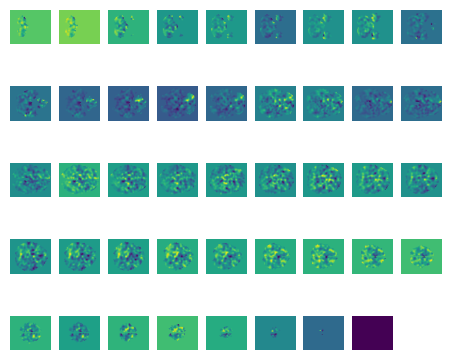

In [8]:
# Visualization for a sample data

row = 5
col = 9

arr = X_train[0,:,:,:]
fig, axes = plt.subplots(nrows=row, ncols=col)
for order, ax in enumerate(axes.flat):

  if order == arr.shape[-1] or order == row*col:
    break

  im = ax.imshow(arr[:,:,order])
  ax.axis('off')

for ax in axes.flat[order:]:
    ax.remove()
fig.subplots_adjust(right=0.8)

plt.show()

In [9]:
print('mean: ', np.mean(arr))
print('max: ', np.max(arr))
print('min: ', np.min(arr))

mean:  -0.02423472933978097
max:  6.3899443812175525
min:  -5.269219783010656


In [10]:
arr = X_train[153,:,:,:]
new_arr = np.where(arr!=0, arr, 0)
print(np.count_nonzero(new_arr))

52109


In [11]:
# --- IMPORTANT CHANGE: NO FLATTENING HERE. Data remains 4D (samples, D, H, W) ---
# We will handle the 3D structure within the model using 3D patch embeddings.
print(f"X_train shape (original 4D): {X_train.shape}")
print(f"X_test shape (original 4D): {X_test.shape}")

# Splitting Dataset
class FMRI_Dataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

X_train shape (original 4D): (3200, 53, 63, 46)
X_test shape (original 4D): (800, 53, 63, 46)


In [12]:
batch_size = 8
train_loader = DataLoader(FMRI_Dataset(X_train, y_train), batch_size, shuffle=True, num_workers=0)
test_loader  = DataLoader(FMRI_Dataset(X_test,  y_test ), batch_size, shuffle=False, num_workers=0)

img_depth, img_height, img_width = X_train.shape[1:]
print(f"Volume dims: {img_depth}×{img_height}×{img_width}")

del X_train, y_train, X_test, y_test  # free RAM

Volume dims: 53×63×46


In [13]:
# ----------------------------------------------------
# 3. Patch embedding
# ----------------------------------------------------
class PatchEmbedding3D(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model):
        super().__init__()
        self.img_d, self.img_h, self.img_w = img_size
        self.pd, self.ph, self.pw        = patch_size
        self.num_patches = math.ceil(self.img_d/ self.pd)*math.ceil(self.img_h/ self.ph)*math.ceil(self.img_w/ self.pw)

        # padding tuple for F.pad (W_left, W_right, H_top, H_bottom, D_front, D_back)
        self.padding = (
            0, (self.pw - self.img_w % self.pw) % self.pw,
            0, (self.ph - self.img_h % self.ph) % self.ph,
            0, (self.pd - self.img_d % self.pd) % self.pd,
        )
        self.proj = nn.Conv3d(in_channels, d_model, kernel_size=patch_size, stride=patch_size)
        self.cls_token   = nn.Parameter(torch.zeros(1,1,d_model))
        nn.init.normal_(self.cls_token, std=0.02)
        self.pos_embed   = nn.Parameter(torch.zeros(1, self.num_patches+1, d_model))
        nn.init.normal_(self.pos_embed, std=0.02)

    def forward(self, x):                      # x: (B, D, H, W)
        x = x.unsqueeze(1)                     # ➜ (B, C=1, D, H, W)
        x = F.pad(x, self.padding)
        x = self.proj(x).flatten(2).transpose(1,2)  # (B, N, d_model)
        cls = self.cls_token.expand(x.size(0), -1, -1)
        x   = torch.cat((cls, x), 1) + self.pos_embed
        return x                               # (B, N+1, d_model)

In [14]:
# ----------------------------------------------------
# 4. Transformer Encoder / Decoder
# ----------------------------------------------------
class ViTEncoder(nn.Module):
    def __init__(self, d_model, n_layers, nhead, dropout):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*4, dropout, batch_first=True)
        self.encoder = nn.TransformerEncoder(layer, n_layers)
    def forward(self, x):
        return self.encoder(x)

class MAEDecoder(nn.Module):
    def __init__(self, d_model, patch_dim, n_layers=1, nhead=2, dropout=0.1):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*2, dropout, batch_first=True)
        self.decoder = nn.TransformerEncoder(layer, n_layers)
        self.out     = nn.Linear(d_model, patch_dim)
    def forward(self, x):
        return self.out(self.decoder(x))


In [15]:
# ----------------------------------------------------
# 5. Masked Autoencoder
# ----------------------------------------------------
class MaskedAutoencoder(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model, n_enc, nhead, dropout, mask_ratio):
        super().__init__()
        self.patch_embed = PatchEmbedding3D(img_size, patch_size, in_channels, d_model)
        self.encoder     = ViTEncoder(d_model, n_enc, nhead, dropout)

        self.mask_ratio  = mask_ratio
        self.d_model     = d_model
        self.N           = self.patch_embed.num_patches
        self.patch_dim   = int(np.prod(patch_size)*in_channels)

        self.mask_token  = nn.Parameter(torch.zeros(1,1,d_model))
        nn.init.normal_(self.mask_token, std=0.02)
        self.decoder     = MAEDecoder(d_model, self.patch_dim, n_layers=1, nhead=nhead, dropout=dropout)

        # fixed Conv3d to extract raw patches (identity weights, no grad)
        self.raw_extract = nn.Conv3d(
            in_channels, self.patch_dim,
            kernel_size=patch_size, stride=patch_size, bias=False)
        with torch.no_grad():
            w = torch.zeros_like(self.raw_extract.weight)
            idx = 0
            for d in range(patch_size[0]):
                for h in range(patch_size[1]):
                    for w_ in range(patch_size[2]):
                        w[idx,0,d,h,w_] = 1.
                        idx += 1
            self.raw_extract.weight.copy_(w)
        for p in self.raw_extract.parameters():
            p.requires_grad=False

    def forward(self, x):                       # x: (B, D, H, W)
        B = x.size(0)

        # -------- raw patches for loss ----------------
        x_pad = F.pad(x.unsqueeze(1), self.patch_embed.padding)
        orig  = self.raw_extract(x_pad).flatten(2).transpose(1,2)  # (B,N,patch_dim)

        # -------- embed & split -----------------------
        seq   = self.patch_embed(x)              # (B, N+1, d)
        cls, patches = seq[:, :1], seq[:, 1:]

        # -------- masking -----------------------------
        num_mask = int(self.N * self.mask_ratio)
        noise    = torch.rand(B, self.N, device=x.device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_mask   = ids_shuffle[:, :num_mask]
        ids_keep   = ids_shuffle[:, num_mask:]

        patches_keep = torch.gather(patches, 1, ids_keep.unsqueeze(-1).expand(-1,-1,self.d_model))
        enc_in = torch.cat([cls, patches_keep], 1)
        enc_out= self.encoder(enc_in)

        # -------- build decoder input -----------------
        mask_tok = self.mask_token.expand(B, num_mask, -1)
        dec_in_full = torch.cat([enc_out[:,1:], mask_tok], 1)  # drop cls for decoder
        dec_in = torch.gather(dec_in_full, 1, ids_restore.unsqueeze(-1).expand(-1,-1,self.d_model))
        recon  = self.decoder(dec_in)            # (B,N,patch_dim)

        # -------- loss --------------------------------
        target_mask = torch.gather(orig, 1, ids_mask.unsqueeze(-1).expand(-1,-1,self.patch_dim))
        pred_mask   = torch.gather(recon,1, ids_mask.unsqueeze(-1).expand(-1,-1,self.patch_dim))
        target_keep = torch.gather(orig, 1, ids_keep.unsqueeze(-1).expand(-1,-1,self.patch_dim))
        pred_keep   = torch.gather(recon,1, ids_keep.unsqueeze(-1).expand(-1,-1,self.patch_dim))

        loss = 0.75*F.mse_loss(pred_mask, target_mask) + 0.25*F.mse_loss(pred_keep, target_keep)
        return loss, ids_mask

In [16]:
# ----------------------------------------------------
# 6. Classifier
# ----------------------------------------------------
class ViTClassifier(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, d_model, n_enc, nhead, dropout, n_classes):
        super().__init__()
        self.patch_embed = PatchEmbedding3D(img_size, patch_size, in_channels, d_model)
        self.encoder     = ViTEncoder(d_model, n_enc, nhead, dropout)
        self.head        = nn.Sequential(
            nn.Linear(d_model, d_model//2), nn.ReLU(), nn.Dropout(dropout), nn.Linear(d_model//2, n_classes)
        )
    def forward(self, x):
        seq = self.patch_embed(x)
        enc = self.encoder(seq)
        cls = enc[:,0]
        return self.head(cls)

In [17]:
# ----------------------------------------------------
# 7. Hyper‑params
# ----------------------------------------------------
patch_size = (5,5,5)
d_model    = 256
n_enc      = 4
nhead      = 8
dropout    = 0.1
mask_ratio = 0.75
num_classes= 2

mae_epochs = 100   # shorten for demo; raise for real training
clf_epochs = 20
mae_lr     = 1e-4
clf_lr     = 1e-4

In [18]:
# ----------------------------------------------------
# 8. Pre‑train MAE
# ----------------------------------------------------
mae = MaskedAutoencoder((img_depth,img_height,img_width), patch_size, 1, d_model, n_enc, nhead, dropout, mask_ratio).to(device)
opt_mae = optim.Adam(mae.parameters(), lr=mae_lr)
sched_mae = optim.lr_scheduler.CosineAnnealingLR(opt_mae,T_max=mae_epochs)
scaler = GradScaler(enabled=device.type=='cuda')

for ep in range(mae_epochs):
    mae.train(); total=0
    for imgs,_ in train_loader:
        imgs = imgs.to(device)
        opt_mae.zero_grad()
        with autocast(device_type='cuda',enabled=device.type=='cuda'):
            loss,_ = mae(imgs)
        scaler.scale(loss).backward(); scaler.step(opt_mae); scaler.update()
        total += loss.item()
    sched_mae.step()
    print(f"MAE {ep+1}/{mae_epochs} loss {total/len(train_loader):.4f} | LR {sched_mae.get_last_lr()[0]:.2e}")
print("MAE pre‑training done\n")

MAE 1/100 loss 0.2335 | LR 1.00e-04
MAE 2/100 loss 0.2169 | LR 9.99e-05
MAE 3/100 loss 0.2158 | LR 9.98e-05
MAE 4/100 loss 0.2156 | LR 9.96e-05
MAE 5/100 loss 0.2153 | LR 9.94e-05
MAE 6/100 loss 0.2151 | LR 9.91e-05
MAE 7/100 loss 0.2150 | LR 9.88e-05
MAE 8/100 loss 0.2154 | LR 9.84e-05
MAE 9/100 loss 0.2150 | LR 9.80e-05
MAE 10/100 loss 0.2150 | LR 9.76e-05
MAE 11/100 loss 0.2149 | LR 9.70e-05
MAE 12/100 loss 0.2149 | LR 9.65e-05
MAE 13/100 loss 0.2150 | LR 9.59e-05
MAE 14/100 loss 0.2149 | LR 9.52e-05
MAE 15/100 loss 0.2148 | LR 9.46e-05
MAE 16/100 loss 0.2149 | LR 9.38e-05
MAE 17/100 loss 0.2148 | LR 9.30e-05
MAE 18/100 loss 0.2151 | LR 9.22e-05
MAE 19/100 loss 0.2148 | LR 9.14e-05
MAE 20/100 loss 0.2148 | LR 9.05e-05
MAE 21/100 loss 0.2148 | LR 8.95e-05
MAE 22/100 loss 0.2148 | LR 8.85e-05
MAE 23/100 loss 0.2148 | LR 8.75e-05
MAE 24/100 loss 0.2147 | LR 8.64e-05
MAE 25/100 loss 0.2149 | LR 8.54e-05
MAE 26/100 loss 0.2148 | LR 8.42e-05
MAE 27/100 loss 0.2147 | LR 8.31e-05
MAE 28/100

In [19]:
# instantiate classifier
clf = ViTClassifier(
    (img_depth, img_height, img_width),
    patch_size, 1,
    d_model, n_enc, nhead, dropout,
    num_classes
).to(device)

# copy encoder weights — note: attribute is *encoder* in your class
clf.encoder.load_state_dict(mae.encoder.state_dict())
print("Encoder weights transferred to classifier")

opt_clf   = optim.Adam(clf.parameters(), lr=clf_lr)
sched_clf = optim.lr_scheduler.StepLR(opt_clf, step_size=int(clf_epochs*0.4), gamma=0.1)
criterion = nn.CrossEntropyLoss()
scaler    = GradScaler(enabled=(device.type == "cuda"))

# ensure checkpoint directory
os.makedirs(SAVE_DIR, exist_ok=True)

best_acc = 0.0
train_losses, test_losses = [], []
train_accs,  test_accs  = [], []

for ep in range(clf_epochs):
    # -------------------- train --------------------
    clf.train(); running_loss = correct = total = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
        opt_clf.zero_grad()
        with autocast(device_type="cuda", enabled=(device.type == "cuda")):
            logits = clf(imgs)
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(opt_clf)
        scaler.update()

        running_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
        total   += labels.size(0)
    sched_clf.step()

    train_losses.append(running_loss / len(train_loader))
    train_accs.append(100 * correct / total)

    # -------------------- validation --------------------
    clf.eval(); val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.squeeze(1).to(device)
            with autocast(device_type="cuda", enabled=(device.type == "cuda")):
                logits = clf(imgs)
                loss   = criterion(logits, labels)
            val_loss += loss.item()
            correct  += (logits.argmax(1) == labels).sum().item()
            total    += labels.size(0)
    test_losses.append(val_loss / len(test_loader))
    val_acc = 100 * correct / total
    test_accs.append(val_acc)

    # save best checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(clf.state_dict(), os.path.join(SAVE_DIR, "best_classifier.pt"))

    print(f"Epoch {ep+1}/{clf_epochs}: train {train_accs[-1]:.2f}% | val {val_acc:.2f}% (best {best_acc:.2f}%)")


Encoder weights transferred to classifier
Epoch 1/20: train 50.66% | val 51.88% (best 51.88%)
Epoch 2/20: train 54.34% | val 57.88% (best 57.88%)
Epoch 3/20: train 61.16% | val 70.50% (best 70.50%)
Epoch 4/20: train 71.56% | val 71.12% (best 71.12%)
Epoch 5/20: train 78.41% | val 76.88% (best 76.88%)
Epoch 6/20: train 81.16% | val 79.88% (best 79.88%)
Epoch 7/20: train 83.31% | val 79.00% (best 79.88%)
Epoch 8/20: train 86.38% | val 81.12% (best 81.12%)
Epoch 9/20: train 90.59% | val 81.00% (best 81.12%)
Epoch 10/20: train 91.75% | val 79.38% (best 81.12%)
Epoch 11/20: train 92.19% | val 80.62% (best 81.12%)
Epoch 12/20: train 92.12% | val 80.25% (best 81.12%)
Epoch 13/20: train 92.97% | val 81.50% (best 81.50%)
Epoch 14/20: train 93.38% | val 81.00% (best 81.50%)
Epoch 15/20: train 93.97% | val 80.88% (best 81.50%)
Epoch 16/20: train 94.31% | val 80.88% (best 81.50%)
Epoch 17/20: train 94.81% | val 80.88% (best 81.50%)
Epoch 18/20: train 95.06% | val 80.50% (best 81.50%)
Epoch 19/20: 

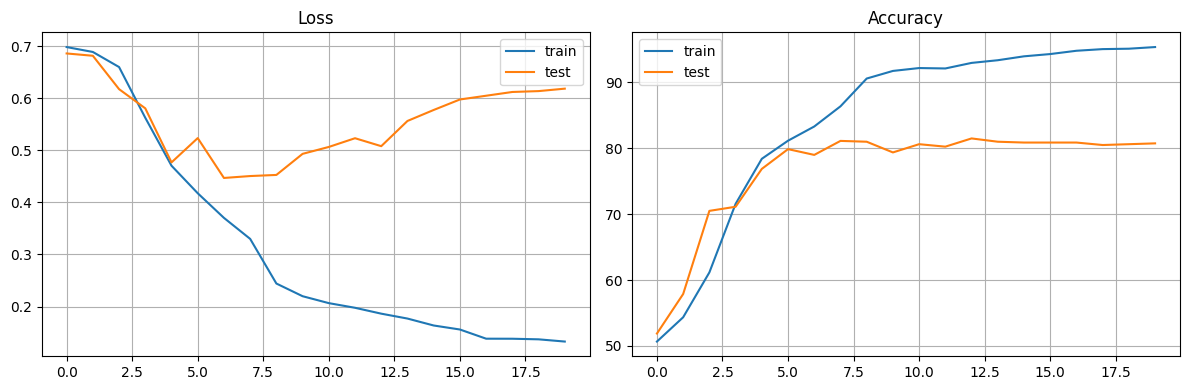

In [20]:
# ----------------------------------------------------
# 10. Plots
# ----------------------------------------------------
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses,label='train'); plt.plot(test_losses,label='test'); plt.title('Loss'); plt.legend(); plt.grid()
plt.subplot(1,2,2)
plt.plot(train_accs,label='train'); plt.plot(test_accs,label='test'); plt.title('Accuracy'); plt.legend(); plt.grid()
plt.tight_layout(); plt.show()

In [21]:
print("completed")

completed
